In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import torch 

%cd /workspace/Walk_Video_PyTorch/project

/workspace/Walk_Video_PyTorch/project


In [2]:
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

import torchmetrics

In [3]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [4]:
from parameters import get_parameters

VIDEO_LENGTH = ['1', '2', '3']
VIDEO_FRAME = ['8', '16', '32']

opt, _ = get_parameters()
opt.num_workers = 8
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

# opt.clip_duration = 2
# opt.uniform_temporal_subsample_num = 30
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
# opt.train_path = '/workspace/data/split_pad_dataset_512/fold3/'

opt.transfor_learning = True
opt.pre_process_flag = True

DATA_PATH = opt.split_pad_data_path

In [5]:
opt.train_path = os.path.join(DATA_PATH, 'flod2')

opt.clip_duration = int(1)
opt.uniform_temporal_subsample_num = int(8)

ckpt_path = '/workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt'

print('#' * 50)
print('the data path: %s' % opt.train_path)
print('ckpt: %s' % ckpt_path)
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.val_dataloader()

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
the data path: /workspace/data/split_pad_dataset_512/flod2
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod2
##################################################


In [6]:
import numpy as np 

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
)

from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import visualization as viz

In [7]:
batch = next(iter(test_data))

video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num
input_tensor = video[6].unsqueeze(dim=0).cuda()


video.shape, label.shape, input_tensor.shape

(torch.Size([8, 3, 8, 224, 224]),
 torch.Size([8]),
 torch.Size([1, 3, 8, 224, 224]))

# Integrated Gradients 

In [8]:
# a series frame show 
def series_attr_show(attributions, raw_img, flag, title):
    '''
    show a series img where combine the raw img with the attr map.

    Args:
        attributions (tensor): attributions map, shape(b, c, f, h, w)
        raw_img (tensor): raw image, shape(b, c, f, h, w)
        flag (str): disease flag, choice [asd, asd_not]
    '''
    
    flag = flag.item()

    # to cpu and numpy
    attributions_ig = attributions.squeeze().cpu().detach().numpy() # c, f, h, w
    raw_img = raw_img.squeeze().cpu().detach().numpy() # c, f, h, w

    attr_ig_transpose = attributions_ig.transpose(1, 0, 2, 3) # f, c, h, w
    raw_img_transpose = raw_img.transpose(1, 0, 2, 3) # f, c, h, w

    f, c, h, w = attr_ig_transpose.shape

    for frame in range(f):

        now_attr_ig = attr_ig_transpose[frame].transpose(1, 2, 0) # h, w, c
        now_raw_img = raw_img_transpose[frame].transpose(1, 2, 0) # h, w, c

        # the attr map and raw img must have shape (h, w, c)
        figure, axis = viz.visualize_image_attr_multiple(now_attr_ig, 
                                now_raw_img,
                                methods=['original_image', 'blended_heat_map'],
                                signs=['all', 'positive'],
                                show_colorbar=True,
                                outlier_perc=1, 
                                cmap='jet',
                                titles=['%s frame' % frame, '%s, label %s' % (title,flag)])


In [9]:
def average_t_show(attributions, raw_img, flag, title):
    
    flag = flag.item()

    # to cpu and numpy
    avg_attr = torch.mean(attributions, dim=2).squeeze().cpu().detach().numpy()
    attributions_ig = attributions.squeeze().cpu().detach().numpy() # c, f, h, w
    
    raw_img = raw_img.squeeze().cpu().detach().numpy() # c, f, h, w

    avg_attr_transpose = avg_attr.transpose(1,2,0)
    raw_img_transpose = raw_img.transpose(1,2,3,0)[2] # f, h, w, c

    figure, axis = viz.visualize_image_attr_multiple(
        avg_attr_transpose,
        raw_img_transpose,
        methods=['original_image', 'blended_heat_map'],
        signs=['all', 'positive'],
        show_colorbar=True,
        outlier_perc=1, 
        cmap='jet',
        titles=['original image', '%s, label %s' % (title, flag)],
    )

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


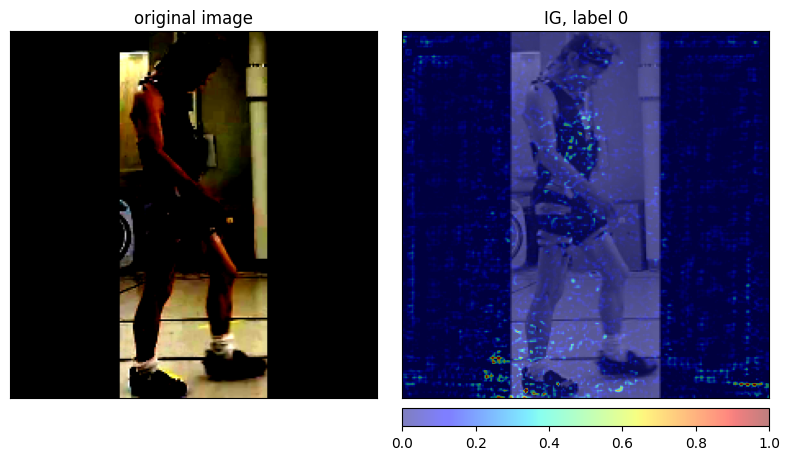

In [10]:
# define the gradient model
ig = IntegratedGradients(model.cuda())

attributions_ig, delta = ig.attribute(input_tensor, target=0, return_convergence_delta=True, internal_batch_size=1)
attributions_ig.shape, delta

# show a series attr with raw img
# series_attr_show(attributions_ig, input, flag=label[2], title='IG')
# show a avg attr on t dimen
average_t_show(attributions_ig, input_tensor, flag=label[2], title='IG')

# Grad CAM

/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Conv3d(1024, 2048, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
IG Attributions: torch.Size([1, 3, 8, 224, 224])


/usr/local/lib/python3.9/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


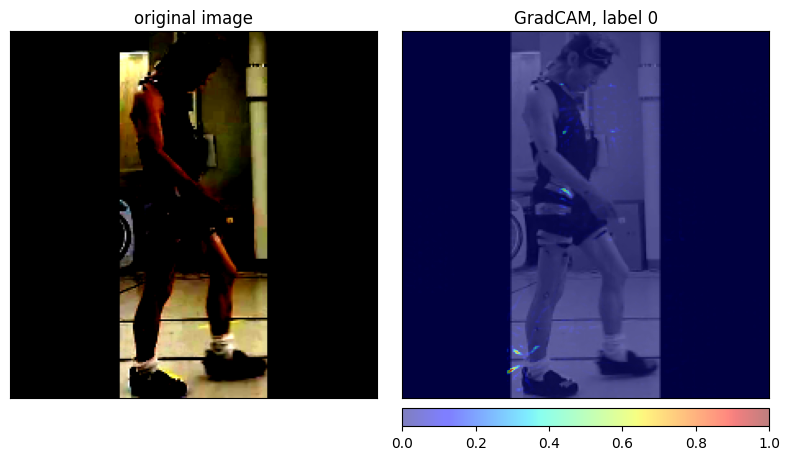

In [11]:
# guided grad cam method
target_layer = model.model.blocks[-2].res_blocks[0].branch1_conv
# target_layer = model.model.blocks[-2].res_blocks[-1].branch2.conv_c

print(target_layer)

guided_gc = GuidedGradCam(model.cuda(), target_layer)

attributions = guided_gc.attribute(input_tensor, target=0, interpolate_mode='nearest', attribute_to_layer_input=False)

print('IG Attributions:', attributions.shape)

# series_attr_show(attributions, input, flag=label[2])

# show t ave dim
average_t_show(attributions, input_tensor, flag=label[2], title='GradCAM')

In [12]:
# deconvolution 
from captum.attr import Deconvolution

deconv = Deconvolution(model.cuda())

input = video[0].unsqueeze(0).cuda()

attributions = deconv.attribute(input, target=0)

In [13]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig = attributions.squeeze().cpu().detach().numpy()
attributions_ig.shape

attributions_ig = attributions_ig.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig.shape, raw_img.shape

((224, 224, 3), (224, 224, 3))

In [14]:
# deep lift 
from captum.attr import DeepLift

dl = DeepLift(model.cuda())

input = video[0].unsqueeze(0).cuda()

attribution = dl.attribute(input, target=0)

/usr/local/lib/python3.9/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [15]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig = attributions.squeeze().cpu().detach().numpy()
attributions_ig.shape

attributions_ig = attributions_ig.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig.shape, raw_img.shape

((224, 224, 3), (224, 224, 3))

# Noise tunnel

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


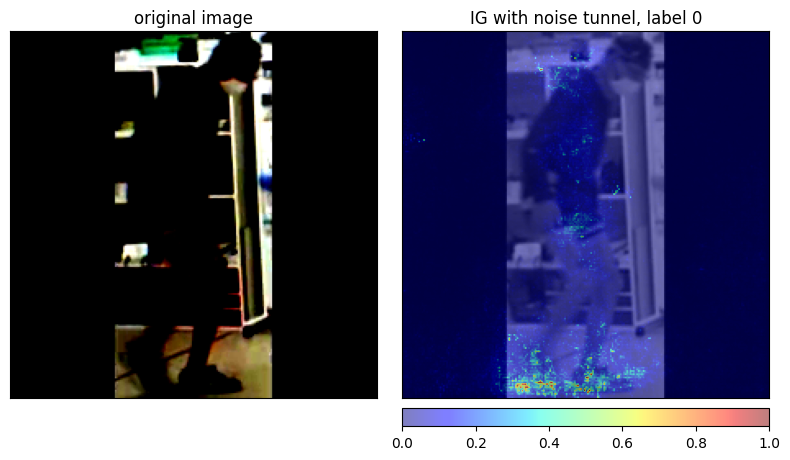

In [16]:
# noise tunnel 
ig = IntegratedGradients(model.cuda())
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_samples=10, nt_type='smoothgrad_sq', target=0, nt_samples_batch_size=1, internal_batch_size=5)


average_t_show(attributions_ig_nt, input, label[2], title='IG with noise tunnel')


In [17]:
# occlusion based attribution
from captum.attr import Occlusion

occlusion = Occlusion(model.cuda())

input = video[0].unsqueeze(0).cuda()

attributions_occ = occlusion.attribute(input,
                                       strides=(3, 1, 40, 40),
                                       target=0, sliding_window_shapes=(3, 4, 60, 60), baselines=0)

# series_attr_show(attributions_occ, video[2], flag=label[2])

# Grad CAM pytorch
use pytorch_grad_cam api to make visilization.

In [18]:
video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num

i=3
input_tensor = video[i].unsqueeze(dim=0).cuda()
inp_label = label[i]


video.shape, label.shape, input_tensor.shape

(torch.Size([8, 3, 8, 224, 224]),
 torch.Size([8]),
 torch.Size([1, 3, 8, 224, 224]))

In [19]:
from pytorch_grad_cam import GradCAM, HiResCAM, FullGrad, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# guided grad cam method
target_layer = [model.model.blocks[-2].res_blocks[-1]]
# target_layer = [ model.model.blocks[-2]]

cam = LayerCAM(model, target_layer, use_cuda=True)

targets = [ClassifierOutputTarget(-1)]

grayscale_cam = cam(input_tensor, aug_smooth=True, eigen_smooth=True)



In [20]:
inp_tensor = input_tensor.squeeze().permute(1,2,3,0)[2].cpu().detach().numpy()
inp_tensor.shape, grayscale_cam.shape

((224, 224, 3), (1, 224, 224, 7))

In [21]:
cam_map = grayscale_cam.mean(axis=3).squeeze()
# cam_map = grayscale_cam[:,:,:,0].squeeze()
cam_map = np.expand_dims(cam_map, 2)

cam_map.shape, type(cam_map)

((224, 224, 1), numpy.ndarray)

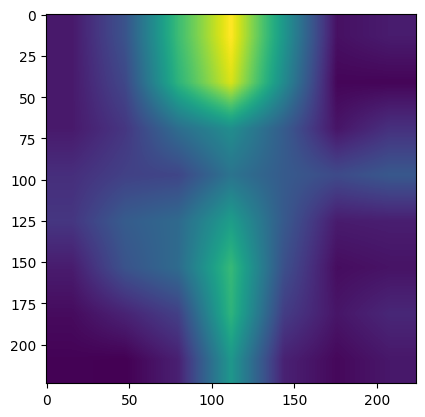

In [22]:
import matplotlib.pyplot as plt 

plt.imshow(cam_map)

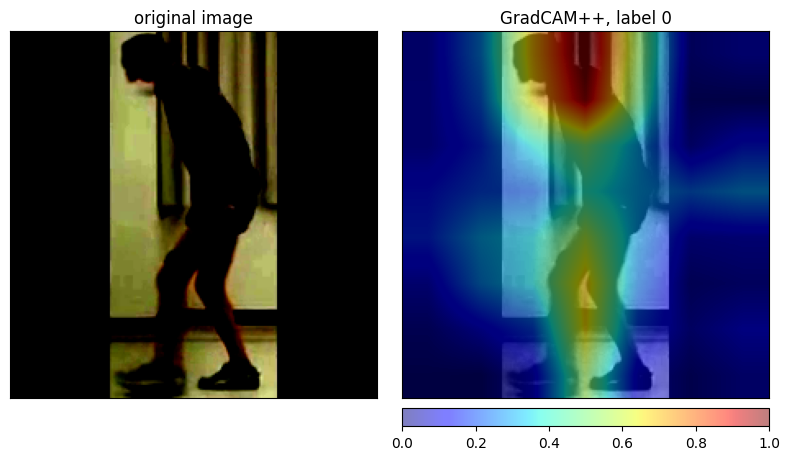

In [23]:
# use captum visual method
figure, axis = viz.visualize_image_attr_multiple(
        cam_map,
        inp_tensor,
        methods=['original_image', 'blended_heat_map'],
        signs=['all', 'positive'],
        show_colorbar=True,
        outlier_perc=1, 
        cmap='jet',
        titles=['original image', 'GradCAM++, label %s' % int(inp_label)]
    )

In [24]:
input_tensor.shape

torch.Size([1, 3, 8, 224, 224])

In [25]:
from torchvision.io import write_video

write_video('1s.mp4', video_array=input_tensor.squeeze().permute(1,2,3,0).detach().cpu(), fps=10)

In [26]:
batch['video_name'][6]

'20180903_1_DHS_lat_V1-0068.mp4'